In [1]:
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# Đảm bảo reproducibility
torch.manual_seed(1)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")


Mounted at /content/drive
✅ Using device: cuda


1 Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

100%|██████████| 312M/312M [00:15<00:00, 21.2MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5


In [3]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.75, scale=(0.01, 0.3), ratio=(1.0, 1.0), value=0, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
data_path = path

full_dataset = datasets.ImageFolder(data_path, transform=None)

# Split 80/20
train_len = int(0.8 * len(full_dataset))
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_len, test_len])

# Wrapper để áp transform khác nhau sau khi split
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_data = TransformDataset(train_dataset, train_transform)
test_data = TransformDataset(test_dataset, test_transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Dataset loaded: {len(train_data)} training samples, {len(test_data)} validation samples.")


✅ Dataset loaded: 10968 training samples, 2743 validation samples.


In [4]:
class_names = full_dataset.classes
print(f"🔍 Có {len(class_names)} lớp: {class_names}")

🔍 Có 23 lớp: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


2 Model

In [5]:
# Load the pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
f_extractor = vgg16.features

# Freeze the feature extraction part (all layers up to the classifier)
layer_count = 0
for child in f_extractor.children():
  if layer_count < 10:
    for param in child.parameters():
      param.requires_grad = False
  layer_count += 1

for name, module in f_extractor.named_modules():
    if hasattr(module, 'parameters'):
        is_trainable = any(param.requires_grad for param in module.parameters())
        print(f"{name}: {'Trainable' if is_trainable else 'Not trainable'}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


: Trainable
0: Not trainable
1: Not trainable
2: Not trainable
3: Not trainable
4: Not trainable
5: Not trainable
6: Not trainable
7: Not trainable
8: Not trainable
9: Not trainable
10: Trainable
11: Not trainable
12: Trainable
13: Not trainable
14: Trainable
15: Not trainable
16: Not trainable
17: Trainable
18: Not trainable
19: Trainable
20: Not trainable
21: Trainable
22: Not trainable
23: Not trainable
24: Trainable
25: Not trainable
26: Trainable
27: Not trainable
28: Trainable
29: Not trainable
30: Not trainable


In [6]:
model = nn.Sequential(f_extractor,
                      nn.Flatten(),
                      nn.Dropout(0.3),
                      nn.Linear(512*7*7, 512),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 23))



model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

3 Train, Evaluate

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [8]:
def train_one_epoch(model, criterion, optimizer, loader):
    model.train()
    total, running_loss, running_correct = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

def evaluate_one_epoch(model, criterion, loader):
    model.eval()
    total, test_loss, running_correct = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = test_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


In [9]:
# Training loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

num_epochs = 20

print("⚙️ Starting training...", flush=True)

for epoch in range(num_epochs):

    train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader)
    test_loss, test_acc = evaluate_one_epoch(model, criterion, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1:02d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} || ",

          flush=True)

print("✅ Training completed.", flush=True)

⚙️ Starting training...
[Epoch 01/20] Train Loss: 1.3681 | Train Acc: 0.5887 || Test Loss: 0.9033 | Test Acc: 0.7313 || 
[Epoch 02/20] Train Loss: 0.7618 | Train Acc: 0.7659 || Test Loss: 0.6979 | Test Acc: 0.7842 || 
[Epoch 03/20] Train Loss: 0.5462 | Train Acc: 0.8310 || Test Loss: 0.7054 | Test Acc: 0.7999 || 
[Epoch 04/20] Train Loss: 0.4071 | Train Acc: 0.8745 || Test Loss: 0.8246 | Test Acc: 0.7820 || 
[Epoch 05/20] Train Loss: 0.3109 | Train Acc: 0.9028 || Test Loss: 0.8883 | Test Acc: 0.7638 || 
[Epoch 06/20] Train Loss: 0.2468 | Train Acc: 0.9235 || Test Loss: 0.8196 | Test Acc: 0.8050 || 
[Epoch 07/20] Train Loss: 0.2192 | Train Acc: 0.9333 || Test Loss: 0.8471 | Test Acc: 0.7926 || 
[Epoch 08/20] Train Loss: 0.1732 | Train Acc: 0.9488 || Test Loss: 0.9169 | Test Acc: 0.7714 || 
[Epoch 09/20] Train Loss: 0.1790 | Train Acc: 0.9451 || Test Loss: 0.9979 | Test Acc: 0.7725 || 
[Epoch 10/20] Train Loss: 0.1570 | Train Acc: 0.9527 || Test Loss: 1.0260 | Test Acc: 0.7721 || 
[Epoch

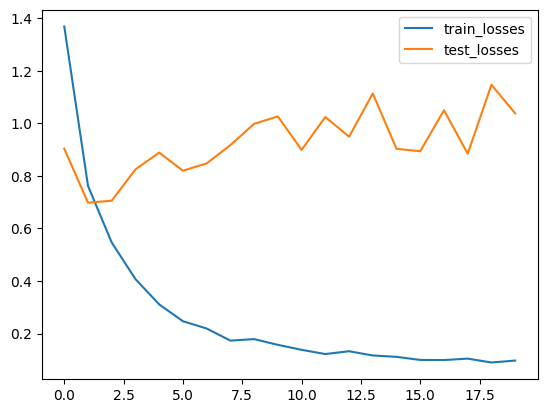

In [10]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

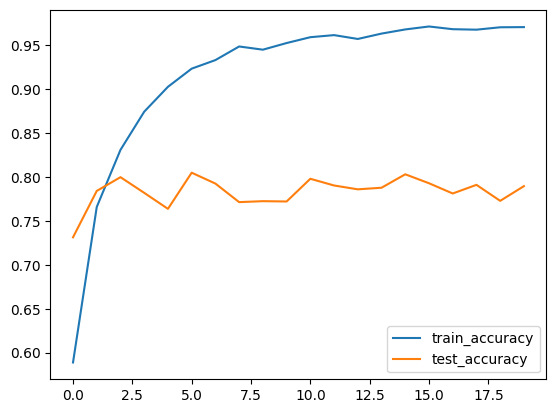

In [11]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [22]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
print("Cache cleared.")

Cache cleared.


Hiển thị 10 ảnh ngẫu nhiên từ tập kiểm thử:


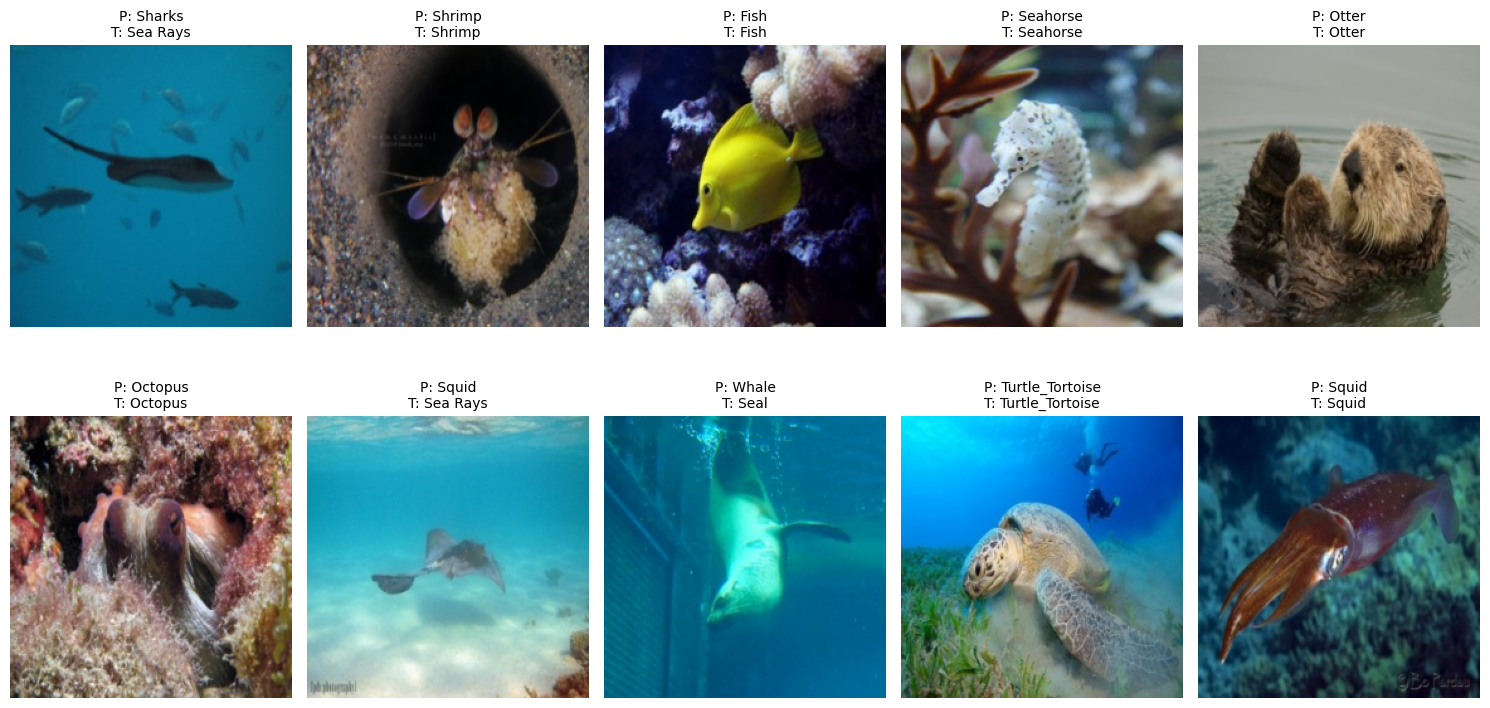

In [21]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Number of random samples to display
num_samples_to_display = 10
random_indices = random.sample(range(len(test_data)), num_samples_to_display)

print(f"Hiển thị {num_samples_to_display} ảnh ngẫu nhiên từ tập kiểm thử:")

# Function to unnormalize images for displaying
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

plt.figure(figsize=(15, 8))

for i, data_index in enumerate(random_indices):
    # Get the image and true label from the test dataset
    image_tensor, true_label_idx = test_data[data_index]
    true_label = class_names[true_label_idx]

    # Make a prediction
    model.eval()
    with torch.no_grad():
        image_input = image_tensor.unsqueeze(0).to(device)
        outputs = model(image_input)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label = class_names[predicted_label_idx.item()]

    # Unnormalize and convert to numpy for displaying
    image_display = unnormalize(image_tensor.clone(), mean, std)
    image_display = image_display.permute(1, 2, 0).cpu().numpy()
    image_display = np.clip(image_display, 0, 1) # Clip values to be between 0 and 1

    # Display the image and prediction
    plt.subplot(2, 5, i + 1) # Arrange images in 2 rows, 5 columns
    plt.imshow(image_display)
    plt.title(f"P: {predicted_label}\nT: {true_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Define the path to save the model
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Transfer learning/Fine_turning_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/Transfer learning/Fine_turning_model.pth
